In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
#Display first row's columns for Measurements 
measurement_dict = session.query(Measurement).first()
measurement_dict.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f91e28cb1c0>,
 'tobs': 65.0,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08}

In [10]:
#Display first row's columns for Station 
station_dict = session.query(Station).first()
station_dict.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f91e28cb760>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397',
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0}

In [11]:
# Create an inspector to inspect the database
inspector = inspect(engine)

# Using the inspector to print the column names
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Create an inspector to inspect the database
inspector = inspect(engine)

# Using the inspector to print the column names
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
#Ensure most recent date is a string and not a row 
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")

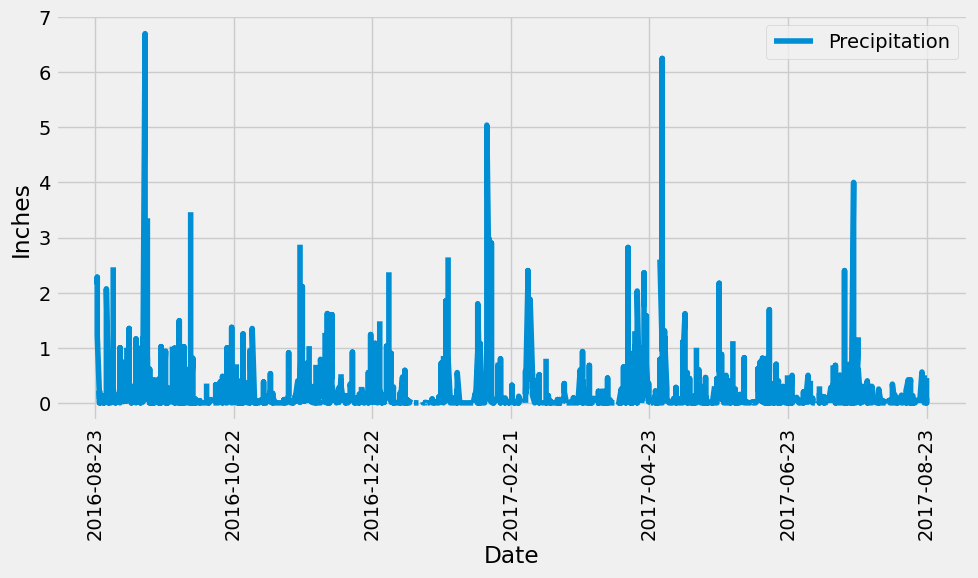

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Convert date column to datetime 
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'], errors='coerce')


# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')


# Use Pandas Plotting with Matplotlib to plot the data
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(precipitation_df['date'], precipitation_df['precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')

# Format the x-ticks
xticks = pd.date_range(start=one_year_ago, end=most_recent_date, periods=7)
plt.xticks(xticks, rotation=90)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df["precipitation"].describe()
summary_statistics = pd.DataFrame(summary_statistics)
summary_statistics

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.id).count()
total_stations

9

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
# List the stations and their counts in descending order.
for station, count in active_stations:
    print(f"Station {station}:{count}")

Station USC00519281:2772
Station USC00519397:2724
Station USC00513117:2709
Station USC00519523:2669
Station USC00516128:2612
Station USC00514830:2202
Station USC00511918:1979
Station USC00517948:1372
Station USC00518838:511


In [18]:
# Most active station 
most_active_station = "USC00519281"
print(f"The most active station is: {most_active_station}")

The most active station is: USC00519281


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()
temperature_stats


[(54.0, 85.0, 71.66378066378067)]

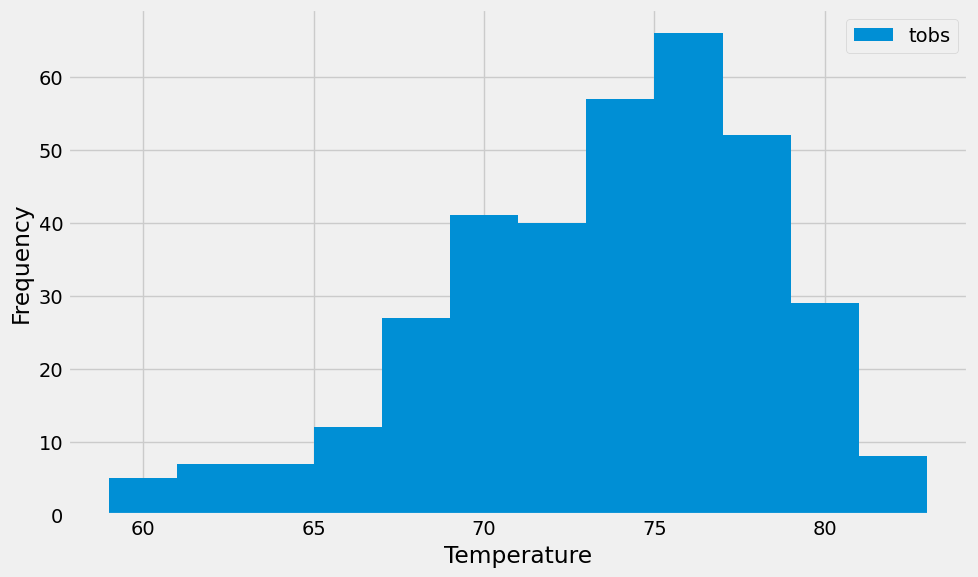

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results into a Pandas DataFrame and set the column names
temperature_df = pd.DataFrame(temperature_data, columns=['date', 'tobs'])

# Plot a histogram with bins=12
plt.figure(figsize=(10, 6))
plt.hist(temperature_df['tobs'], bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [21]:
# Close Session
session.close()